# Skin Cancer Detection using MLCV

### Installer des bibliothèques et faire les imports nécessaires

In [9]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pydot
%pip install pydot graphviz
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetB0 # type: ignore #ingore the warning
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, Flatten, GlobalAveragePooling2D # type: ignore #ingore the warning
from tensorflow.keras.models import Model, Sequential # type: ignore #ingore the warning
from tensorflow.keras.optimizers import Adam # type: ignore #ingore the warning
from tensorflow.keras.utils import plot_model # type: ignore #ingore the warning
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore #ingore the warning
from tensorflow.keras.applications.efficientnet import preprocess_input # type: ignore #ingore the warning
from tensorflow.keras.callbacks import TensorBoard # type: ignore #ingore the warning
from sklearn.model_selection import train_test_split


### Définition de la fonction de traçage de courbes

In [11]:
def display_training_curves(training, validation, title, subplot):
    """
    Titre: Afficher les courbes d'entraînement

    Description:
    Cette fonction trace les courbes d'entraînement et de validation pour une métrique donnée (par exemple, précision, perte) au fil des époques.
    Elle configure les sous-graphiques, personnalise l'apparence et ajoute des légendes et des étiquettes pour une meilleure visualisation.

    Arguments:
        training (liste ou tableau): Les points de données d'entraînement à tracer.
        validation (liste ou tableau): Les points de données de validation à tracer.
        title (str): Le titre du graphique, généralement le nom de la métrique tracée.
        subplot (int): L'index du sous-graphe à utiliser pour le graphique actuel (1 ou 2).

    Retour:
        Aucun
    """
    if subplot == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    plt.subplot(2, 1, subplot)  # S'assurer d'avoir un bon placement dans la grille (2x1)
    plt.gca().set_facecolor('#F8F8F8')  # change the background color
    plt.plot(training)
    plt.plot(validation)
    plt.title('model ' + title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid.'])

### Détecter le hardware à disposition (TPU, GPU ou CPU dans cet ordre de priorité)

In [12]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
#If TPU not found try with GPUs
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


### Créer un tableau regroupant les chemins des images ainsi que leurs principales caractéristiques (label, âge, sexe)

In [20]:
# Charger le fichier CSV
metadata = pd.read_csv("./DataBase/Images/metadata.csv")

# Ajouter le chemin complet des images
metadata['image_path'] = metadata['isic_id'].apply(lambda x: f"./DataBase/Images/{x}.jpg")

# Encoder les labels (0 = benign, 1 = malignant)
metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})

metadata = metadata.dropna(subset=['label'])
metadata = metadata[['image_path', 'label', 'age_approx','sex']]
print(metadata.head())




                            image_path      label  age_approx   sex
0   ./DataBase/Images/ISIC_9481737.jpg  malignant          30  male
1   ./DataBase/Images/ISIC_0848988.jpg  malignant          30  male
59  ./DataBase/Images/ISIC_0024295.jpg  malignant          30  male
60  ./DataBase/Images/ISIC_0024155.jpg     benign          30  male
61  ./DataBase/Images/ISIC_0024154.jpg     benign          30  male


### Définition des paramètres globaux pour l'entrainement du modèle

In [14]:
# Chemins vers les fichiers TFRecord (désactivé dans cet exemple)
# TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
# TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')

# Taille des lots adaptée au nombre de répliques (dispositifs GPU/TPU) disponibles
BATCH_SIZE = 10 * strategy.num_replicas_in_sync  # Par exemple, 10 images par réplique

# Taille des images à utiliser (100x100 pixels)
IMAGE_SIZE = [100, 100]  # Taille utilisée pour le redimensionnement des images
imSize = 100             # Taille utilisée pour redimensionner les images dans les pipelines

# Optimisation automatique pour le préchargement des données
AUTO = tf.data.experimental.AUTOTUNE

# Nombre d'époques (itérations sur l'ensemble d'entraînement)
EPOCHS = 20  # Peut être ajusté en fonction des performances et de la convergence

# Définir l'entrée du modèle (couche d'entrée pour TensorFlow/Keras)
input_layer = Input(shape=(imSize, imSize, 3))  # Entrée avec une image RGB (3 canaux)

## Traitement des métadonnées, classifications en batch (train, validate, test) et création des dataset TensorFlow

### Chargement et prétraitement des métadonnées

In [28]:
# Chargement du fichier CSV contenant les métadonnées
metadata = pd.read_csv("./DataBase/Images/metadata.csv")
if metadata.isnull().any().any():
    print("Des valeurs manquantes ont été détectées.")
    
# Ajouter les chemins complets des images
metadata['image_path'] = metadata['isic_id'].apply(lambda x: f"./DataBase/Images/{x}.jpg")

# metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})
metadata['label'] = metadata['benign_malignant']

# Supprimer les lignes avec des valeurs manquantes
metadata = metadata.dropna(subset=['label'])

print(f"Nombre total d'images disponibles : {len(metadata)}")
print(metadata['benign_malignant'].isnull().sum())
print(metadata['benign_malignant'].unique())
print(f"Total rows in original CSV: {metadata.shape[0]}")

Des valeurs manquantes ont été détectées.
Nombre total d'images disponibles : 10
0
['malignant' 'benign']
Total rows in original CSV: 10


In [29]:
print(metadata['label'].value_counts())

label
malignant    6
benign       4
Name: count, dtype: int64


### Division des données en ensembles d’entraînement, validation et test

In [17]:
# Division des ensembles en entraînement (70%), validation (20%), et test (10%)
train_metadata, temp_metadata = train_test_split(
    metadata, 
    test_size=0.3,  # 30 % seront partagés entre validation et test
    stratify=metadata['label'],  # Assurer un équilibre des classes
    random_state=42
)

val_metadata, test_metadata = train_test_split(
    temp_metadata, 
    test_size=0.33,  # 1/3 des 30 % pour test, soit ~10 % au total
    stratify=temp_metadata['label'], 
    random_state=42
)

print(f"Entraînement : {train_metadata.shape[0]} exemples")
print(f"Validation : {val_metadata.shape[0]} exemples")
print(f"Test : {test_metadata.shape[0]} exemples")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### Définition des fonctions pour charger et prétraiter les données

In [18]:
# Fonction pour charger et prétraiter une image
def load_image_and_label(image_path, label):
    """
    Charge une image depuis son chemin, applique des prétraitements
    (normalisation, redimensionnement), et retourne l'image et son étiquette.
    """
    # Charger l'image depuis son chemin
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Décode une image JPEG en RGB
    
    # Normaliser les valeurs des pixels (entre 0 et 1)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Redimensionner l'image à une taille standard
    image = tf.image.resize(image, [imSize, imSize])
    
    return image, label

# Fonction pour convertir un DataFrame Pandas en dataset TensorFlow
def create_tf_dataset(metadata_df, batch_size):
    """
    Convertit un DataFrame contenant les chemins des images et les étiquettes 
    en un dataset TensorFlow optimisé pour l'entraînement.
    """
    # Extraction des colonnes nécessaires depuis le DataFrame
    image_paths = metadata_df['image_path'].values
    labels = metadata_df['label'].values
    
    # Créer un dataset TensorFlow à partir des chemins et des étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Appliquer la fonction de chargement et de prétraitement
    dataset = dataset.map(load_image_and_label, num_parallel_calls=AUTO)
    
    # Diviser en lots et activer le préchargement pour optimiser les performances
    dataset = dataset.batch(batch_size).prefetch(AUTO)
    
    return dataset

#### Test d'affichage de quelques images du dataset

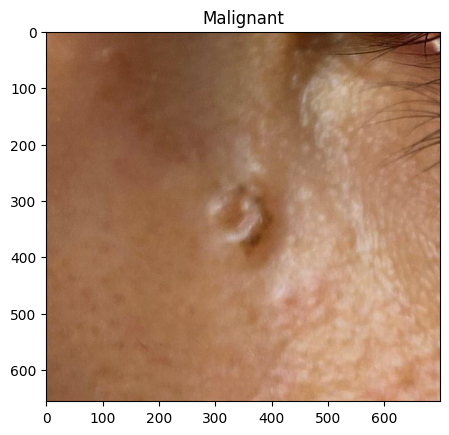

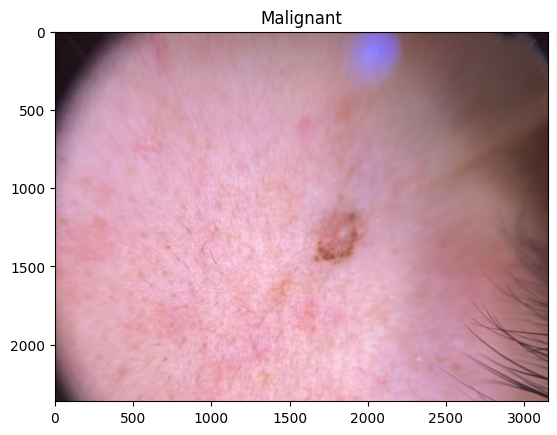

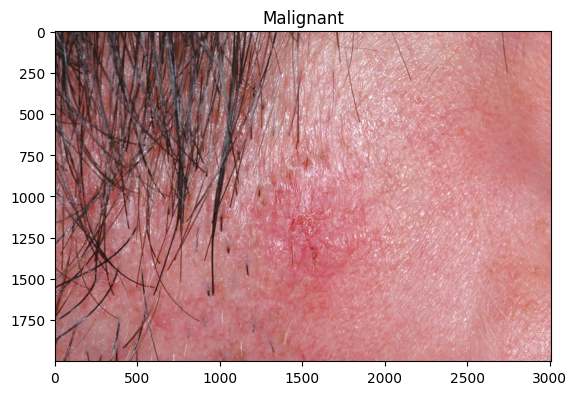

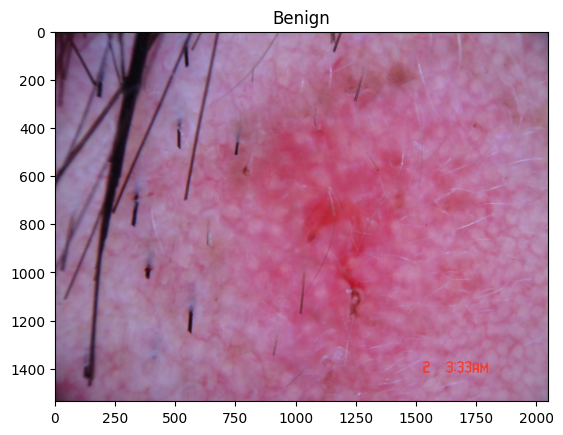

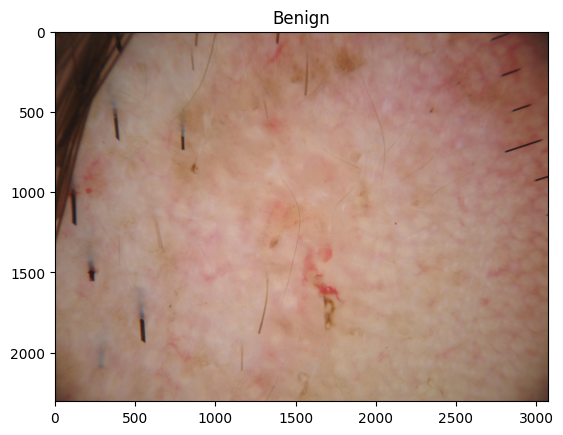

In [19]:
for img_path, label in metadata[['image_path', 'label']].values[:5]:
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"{'Malignant' if label == 1 else 'Benign'}")
    plt.show()

### Création des datasets TensorFlow

In [ ]:
# Créer les datasets
training_dataset = create_tf_dataset(train_metadata, batch_size=BATCH_SIZE)
validation_dataset = create_tf_dataset(val_metadata, batch_size=BATCH_SIZE)
test_dataset = create_tf_dataset(test_metadata, batch_size=BATCH_SIZE)

print(f"Training dataset : {len(training_dataset)} batches")
print(f"Validation dataset : {len(validation_dataset)} batches")
print(f"Test dataset : {len(test_dataset)} batches")

### Calcul des paramètres pour l’entraînement

In [ ]:
# Calcul des paramètres pour l'entraînement
STEPS_PER_EPOCH = len(training_dataset) // BATCH_SIZE
VALIDATION_STEPS = len(validation_dataset) // BATCH_SIZE 

print(f"Nombre total de lots pour l'entraînement : {STEPS_PER_EPOCH}")
print(f"Nombre total de lots pour la validation : {VALIDATION_STEPS}")

### Charger le modèle (sans couche de classification finale)

In [ ]:
# Charger le modèle EfficientNetB0 préentraîné sans la couche de classification finale
with strategy.scope():
    base_model = tf.keras.Sequential([
        EfficientNetB0(
            input_shape=(imSize, imSize, 3),
            weights='imagenet',
            include_top=False
        )
    ])

# Geler les couches du modèle de base pour conserver les poids préentraînés
base_model.trainable = False

In [ ]:
# Passer l'entrée à travers le modèle de base
x = base_model(input_layer, training=False)  # `input_layer` 
x = Flatten()(x)  # Aplatir les caractéristiques extraites


# Ajout de couches fully connected pour la classification
x = Dense(128, activation="relu")(x)  # Couche dense
x = Dropout(0.5)(x)  # Dropout pour régularisation
output = Dense(1, activation="sigmoid")(x)  # Sigmoid pour une classification binaire

# Définir le modèle final avec une seule entrée (image)
model = Model(inputs=input_layer, outputs=output)

### Compiler le modèle

In [ ]:
model.compile(
    optimizer='adam',  # Optimiseur Adam
    loss="binary_crossentropy",          # Fonction de perte pour la classification binaire
    metrics=["accuracy"]                 # Suivi de la précision
)

# Résumé du modèle
model.summary()

In [ ]:
# Visualisation de l'architecture du modèle
# plot_model(model, show_shapes=True, to_file="efficientnetb0_model.png")

In [ ]:
def learning_rate_function(epoch):
    LR_START = 0.00001 # Taux d'apprentissage initial
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync # Taux d'apprentissage maximal
    LR_MIN = 0.00001 # Taux d'apprentissage minimal
    LR_RAMPUP_EPOCHS = 5 # nombre d'époques pendant lesquelles le taux d'apprentissage augmente linéairement.
    LR_SUSTAIN_EPOCHS = 0 # nombre d'époques où le taux reste maximal
    LR_EXP_DECAY = .8 # taux de décroissance exponentielle du taux d'apprentissage après les périodes de "ramp-up" et de "soutien"
    

    # Augmentation (pour les premières LR_RAMPUP_EPOCHS époques) : le taux d'apprentissage commence à LR_START et monte linéairement jusqu'à LR_MAX
    if epoch < LR_RAMPUP_EPOCHS: 
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START

    # Soutien (pour les LR_SUSTAIN_EPOCHS suivantes) : le taux d'apprentissage reste constant à LR_MAX
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    # Décroissance (pour les époques restantes) : le taux d'apprentissage diminue exponentiellement
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose=1)

In [ ]:
log_dir = os.path.join("logs", "fit", "model_name")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(training_dataset, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                    validation_data=validation_dataset,callbacks=[lr_schedule,tensorboard_callback],)

In [ ]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 2)

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 2)

In [ ]:
# Fonction pour charger les matrices Y, Cb, Cr à partir du fichier
def load_ycbcr_from_file(file_path):
    """
    Charger les matrices Y, Cb, Cr à partir d'un fichier texte.
    Les fichiers doivent contenir trois sections avec des matrices pour chaque composante.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Identifier les sections et extraire les matrices
    y_start = lines.index("Matrice de luminance (Y):\n") + 1
    cb_start = lines.index("Matrice de chrominance (Cb):\n") + 1
    cr_start = lines.index("Matrice de chrominance (Cr):\n") + 1

    y = np.loadtxt(lines[y_start:cb_start - 1], dtype=np.float32)
    cb = np.loadtxt(lines[cb_start:cr_start - 1], dtype=np.float32)
    cr = np.loadtxt(lines[cr_start:], dtype=np.float32)

    return y, cb, cr

In [ ]:
# Fonction pour préparer l'entrée pour le modèle
def prepare_ycbcr_input(y, cb, cr):
    """
    Prépare l'entrée pour le modèle à partir des matrices Y, Cb, Cr.
    """
    # Empiler les canaux Y, Cb, Cr pour former une image (100, 100, 3)
    image = np.stack([y, cb, cr], axis=-1)  # Shape: (100, 100, 3)

    # Normaliser l'image (en utilisant une normalisation simple, pas celle d'ImageNet)
    image = image / 255.0  # Normalisation simple entre 0 et 1

    # Ajouter la dimension du batch (1, 100, 100, 3)
    image = np.expand_dims(image, axis=0)

    return image

In [ ]:
# Fonction de prédiction
def predict_skin_cancer(file_path):
    """
    Prédire à partir des matrices Y, Cb, Cr chargées depuis un fichier.
    """
    # Charger les matrices Y, Cb, Cr à partir du fichier
    y, cb, cr = load_ycbcr_from_file(file_path)

    # Préparer l'entrée pour le modèle
    ycbcr_input = prepare_ycbcr_input(y, cb, cr)


    # Prédiction
    prediction = model.predict(ycbcr_input)

    # Interprétation
    if prediction[0] > 0.5:
        return f"Maligne (probabilité {prediction[0][0]:.2f})"
    else:
        return f"Bénigne (probabilité {1 - prediction[0][0]:.2f})"

# Exemple d'utilisation
file_path = "./DataBase/Matrices/ISIC_0001120_matrices.txt"
result = predict_skin_cancer(file_path)
print(result)